# AI Open Session
You will be building a Neural Net that can categorise images. We will be:
1. Creating a dataset by downloading images from Google Images
2. Training a model to recognise those images
3. Testing it on new images to see if it can recognise those too.

Based on a notebook from the [fastai course](https://course.fast.ai/) by Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

## Install dependencies
Click the "Play" button on the left of the cell below to run it.

Alternatively, click on the cell, then use Shift-Enter to run it

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"
from fastai.vision import *

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 56.8MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


# 1. Creating your own dataset from Google Images

## Get a list of URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show particular types of images.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. 

In **Google Chrome** press **<kbd>Ctrl</kbd>-<kbd>Shift</kbd>-<kbd>j</kbd>** on Windows/Linux and <kbd>Cmd</kbd>-<kbd>Opt</kbd>-<kbd>j</kbd> on macOS, and a small window the javascript 'Console' will appear. 

In **Firefox** press **<kbd>Ctrl</kbd>-<kbd>Shift</kbd>-<kbd>k</kbd>** on Windows/Linux or <kbd>Cmd</kbd>-<kbd>Opt</kbd>-<kbd>k</kbd> on macOS.

### Paste the following into the console window and hit <kbd>Enter</kbd>

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

You should now have a file in your Downloads directory called `download`

Use file explorer to go to the Downloads directory and **rename the file** - if these are spiderman images, for example, call it `spiderman.txt`

### Repeat the above steps until you have 2 or 3 different categories of images

### Get Access to Google Drive
1. Run the cell below
2. Click on the link that appears
3. Select your Google account and allow access
4. Paste the access code into box below & hit <kbd>Enter</kbd>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AFjfx2UGQscoEoQgzLQoupBh625EBpjL7qltMnLTfMCMWq6jVYR5NM
Mounted at /content/gdrive


In [3]:
!ls "gdrive/My Drive/Colab Notebooks"


AI_Open_Session.ipynb  data  v2_production.ipynb


### Upload files to Google Drive
1. Go to your [Google Drive](https://drive.google.com/drive/u/0/my-drive)
2. Go to the `Colab Notebooks` folder
3. Create a new folder called `data`
4. Go to the new data folder
5. Drag & drop your .txt files from File Explorer into the data folder
6. Wait for the upload to complete

If that all went smoothly, when you run the cell below you should see the files you just uploaded.

In [4]:
!ls "gdrive/My Drive/Colab Notebooks/data"

bears.pkl   exportxx.pkl  models	 teddy.txt
black.txt   grizzly.txt   spiderman.txt  wonderwoman.txt
export.pkl  hulk.txt	  superman.txt


### Download the images to your Google Drive

First, edit the list of categories below to match your .txt file names:

In [5]:
categories = ['spiderman', 'superman', 'hulk', 'wonderwoman']

In [6]:
# Create some folders to store the images for each category
path = Path('gdrive/My Drive/Colab Notebooks/data')
for cat in categories:
  dest = path/cat
  dest.mkdir(parents=True, exist_ok=True)

In [7]:
# Now download the images - may take a few minutes!
for cat in categories:
  file=f"{cat}.txt"
  print(path/file)
  download_images(path/file, path/cat, max_pics=200)

gdrive/My Drive/Colab Notebooks/data/spiderman.txt


gdrive/My Drive/Colab Notebooks/data/superman.txt


gdrive/My Drive/Colab Notebooks/data/hulk.txt


gdrive/My Drive/Colab Notebooks/data/wonderwoman.txt


In [ ]:
# If you have problems downloading, try with `max_workers=0` to see exceptions:
# download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [8]:
for c in categories:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

spiderman


superman


hulk


wonderwoman


## View data
Go to your Google Drive, and look at the images which are now in your new category sub-folders - delete anything that isn't a useful image for that category.

### Create a database of the new images

In [19]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

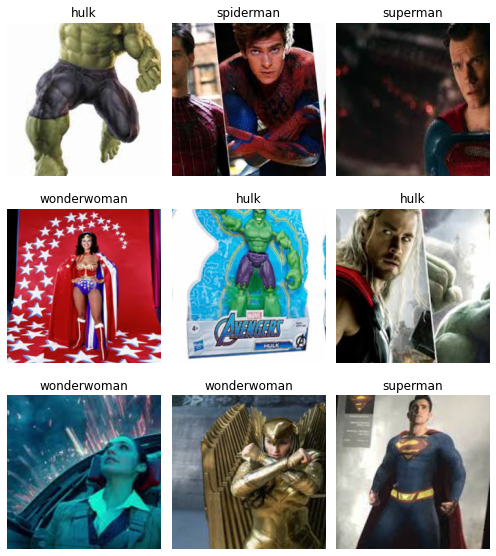

In [10]:
data.show_batch(rows=3, figsize=(7,8))

# 2. Train model
Create a "learner" this has our model, and the the functions needed to train it.

We are using a "resnet34" which is a commonly used architecture for image recognition. The 34 refers to the number of "layers" (or how complex the model is)

In [20]:
learn = cnn_learner(data, models.resnet34, callback_fns=[ShowGraph], metrics=accuracy)

Now we need to find a good "Learning Rate" for our data. If we pick too low a Learning Rate, it will take forever to train our model. Too high and the process goes unstable and the model does not learn at all

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


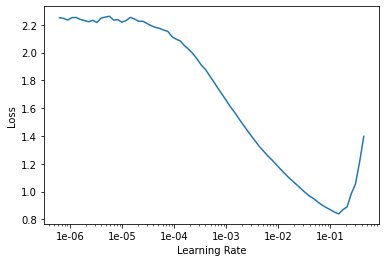

In [17]:
learn.lr_find(); learn.recorder.plot()

We want a value towards the bottom of the steepest part of the slope, but not too close to where the curve starts to turn upwards again

Now we start training our model:

epoch,train_loss,valid_loss,accuracy,time
0,1.932167,0.645105,0.765101,00:06
1,1.136306,0.479916,0.872483,00:06
2,0.808525,0.420811,0.865772,00:06
3,0.616134,0.403903,0.885906,00:06
4,0.520353,0.401376,0.899329,00:06


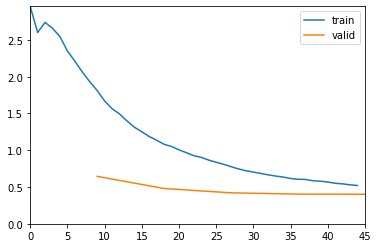

In [21]:
learn.fit_one_cycle(5, max_lr=3e-3)

Save our model:

In [22]:
learn.save('stage-1')

By default, fastai stops us from training all the layers in the model at first. This allows the model to learn "the basics" about our categories. But now we want to do some "fine tuning" on the whole model, so we "unfreeze" it:

In [23]:
learn.unfreeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


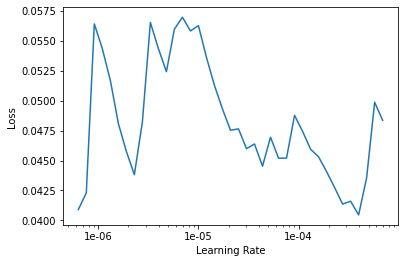

In [23]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

You can think of our model as having 2 parts - the "generic image recognition" bit and the "recognise my categories" bit - we are going to train these two parts at different learning rates - the lower one is for the "generic image recognition"

epoch,train_loss,valid_loss,accuracy,time
0,0.198631,0.380503,0.899329,00:06
1,0.180107,0.370118,0.892617,00:06
2,0.157307,0.353714,0.892617,00:06


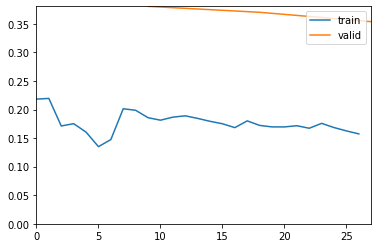

In [24]:
learn.fit_one_cycle(3, max_lr=slice(3e-5,1e-4))

In [25]:
learn.save('stage-2')

## Interpretation

In [ ]:
#learn.load('stage-2');

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

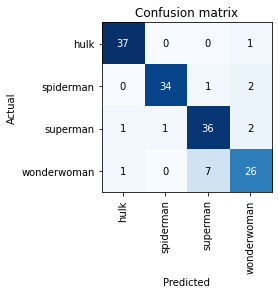

In [26]:
interp.plot_confusion_matrix()

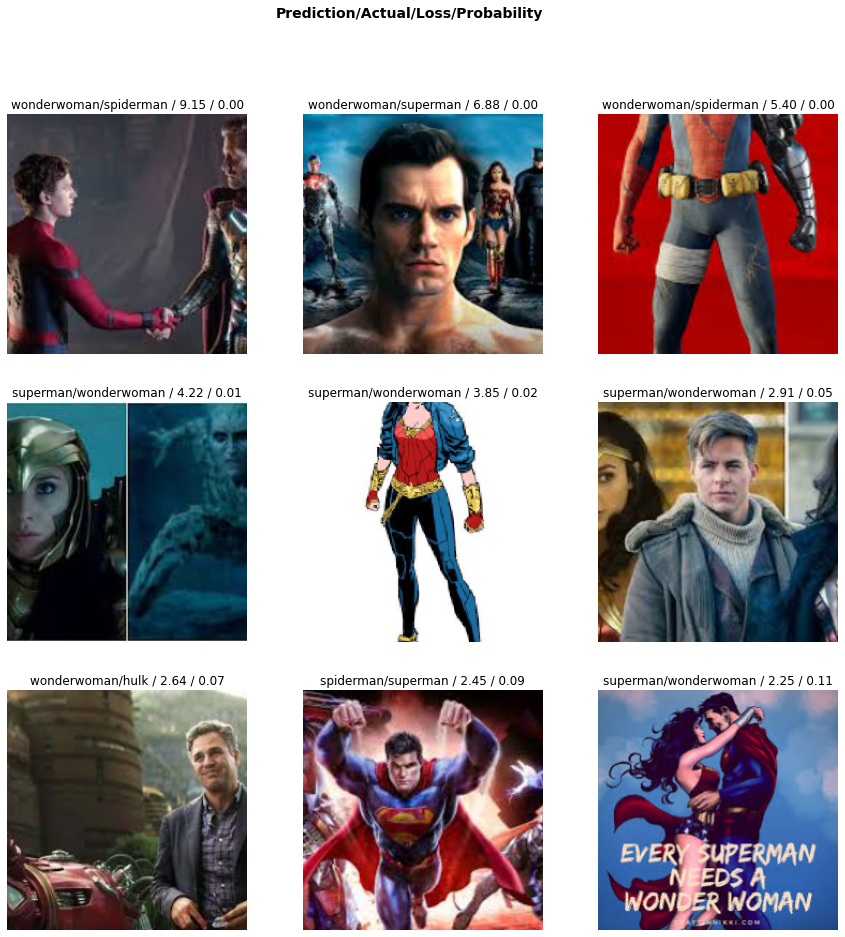

In [27]:
interp.plot_top_losses(9, figsize=(15,15))

# 3. Putting Our Model Into Production

First thing first, let's export the content of our `Learner` object for production:

In [28]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

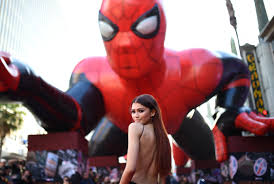

In [29]:
img = open_image(path/'spiderman'/'00000009.jpg')
img

We create our `Learner` in production environment like this, just make sure that `path` contains the file 'export.pkl' from before.

In [30]:
learn2 = load_learner(path)

Now we can use our new learner to do a prediction on the image above

In [31]:
pred_class,pred_idx,outputs = learn2.predict(img)
pred_class.obj

'spiderman'

# Use ipywidgets to make an "App"

In [32]:
import ipywidgets as widgets
from PIL import Image as pim
import numpy as np
import io

In [33]:
def pil2tensor(image:Union[NPImage,NPArray],dtype:np.dtype)->TensorImage:
    "Convert PIL style `image` array to torch style image tensor."
    a = np.asarray(image)
    if a.ndim==2 : a = np.expand_dims(a,2)
    a = np.transpose(a, (1, 0, 2))
    a = np.transpose(a, (2, 1, 0))
    return torch.from_numpy(a.astype(dtype, copy=False) )

def create_image(fn:bytes, div:bool=True, convert_mode:str='RGB')->Image:
    "Return `Image` object created from image in bytes `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(io.BytesIO(fn)).convert(convert_mode)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return Image(x)


In [34]:
btn_upload = widgets.FileUpload(multiple=False)
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')

out_pl = widgets.Output()
out_pl.clear_output()

def on_click_classify(change):
    img = create_image(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img)
    pred,pred_idx,probs = learn2.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]*100:.02f}%'

btn_run.on_click(on_click_classify)

In [36]:
widgets.VBox([widgets.Label('Select your image'), 
      btn_upload, btn_run, out_pl, lbl_pred])